In [1]:
import os
try:
    inpath = "../input/data/" #Kaggle
    print(os.listdir(inpath))
except FileNotFoundError:
    inpath = "./" #Local
    print(os.listdir(inpath))

['images_003', 'images_012', 'LOG_CHESTXRAY.pdf', 'README_CHESTXRAY.pdf', 'BBox_List_2017.csv', 'images_009', 'images_008', 'images_007', 'test_list.txt', 'images_010', 'ARXIV_V5_CHESTXRAY.pdf', 'images_002', 'images_011', 'Data_Entry_2017.csv', 'images_001', 'train_val_list.txt', 'images_005', 'FAQ_CHESTXRAY.pdf', 'images_004', 'images_006']


In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Found GPU at: /device:GPU:0


In [3]:
import pandas as pd
data = pd.read_csv(inpath + 'Data_Entry_2017.csv')
print(f"The dimensions of the data set are: {data.shape}")

data.head()

The dimensions of the data set are: (112120, 12)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [4]:
data = data[data['Patient Age']<100]
print(f"The dimensions of the data set are: {data.shape}")

The dimensions of the data set are: (112104, 12)


In [5]:
data = data[['Image Index', 'Finding Labels']]
print(f"The dimensions of the data set are: {data.shape}")

The dimensions of the data set are: (112104, 2)


In [6]:
"""
We read all the routes of the images
"""
from glob import glob
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input','data','images*','images','*.png'))}
print('Images found:', len(all_image_paths))

"""
Add the path column to the dataset
"""
data['Path'] = data['Image Index'].map(all_image_paths.get)

data.sample(5, random_state=3)

Images found: 112120


,Image Index,Finding Labels,Path
13531,00003520_002.png,No Finding,../input/data/images_002/images/00003520_002.png
45241,00011598_037.png,Effusion|Mass,../input/data/images_006/images/00011598_037.png
40313,00010503_000.png,Infiltration,../input/data/images_005/images/00010503_000.png
81272,00019962_006.png,No Finding,../input/data/images_009/images/00019962_006.png
85415,00021047_013.png,No Finding,../input/data/images_010/images/00021047_013.png


In [7]:
"""
Create a np array with all the single deseases
"""
import numpy as np
from itertools import chain
all_labels = np.unique(list(chain(*data['Finding Labels'].map(lambda x: x.split('|')).tolist())))

all_labels

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'], dtype='<U18')

In [8]:
all_labels = np.delete(all_labels, np.where(all_labels == 'No Finding'))
print(f'Current type: {type(all_labels)}')

all_labels = [x for x in all_labels]
print(f'Final type: {type(all_labels)}')

print(f'Diseases: ({len(all_labels)}): {all_labels}')

Current type: <class 'numpy.ndarray'>
Final type: <class 'list'>
Diseases: (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [9]:
"""
We add a column, for each disease
"""
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        # Add a column for each desease
        data[c_label] = data['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
        
print(f"The dimensions of the data set are: {data.shape}")
data.head()

The dimensions of the data set are: (112104, 17)


,Image Index,Finding Labels,Path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,../input/data/images_001/images/00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,../input/data/images_001/images/00000001_001.png,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,../input/data/images_001/images/00000001_002.png,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,../input/data/images_001/images/00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,Hernia,../input/data/images_001/images/00000003_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [10]:
label_counts = data['Finding Labels'].value_counts()
label_counts

No Finding                                                       60353
Infiltration                                                      9546
Atelectasis                                                       4214
Effusion                                                          3955
Nodule                                                            2705
                                                                 ...  
Atelectasis|Consolidation|Effusion|Fibrosis|Infiltration|Mass        1
Edema|Infiltration|Mass|Nodule                                       1
Consolidation|Pleural_Thickening|Infiltration                        1
Edema|Fibrosis|Infiltration|Mass                                     1
Effusion|Infiltration|Mass|Nodule|Pneumonia                          1
Name: Finding Labels, Length: 836, dtype: int64

In [11]:
data = data.groupby('Finding Labels').filter(lambda x : len(x)>11)

In [12]:
label_counts = data['Finding Labels'].value_counts()
print(label_counts.shape)
label_counts

(198,)


No Finding                                                      60353
Infiltration                                                     9546
Atelectasis                                                      4214
Effusion                                                         3955
Nodule                                                           2705
                                                                ...  
Edema|Emphysema                                                    13
Effusion|Emphysema|Infiltration|Pneumothorax                       12
Atelectasis|Cardiomegaly|Consolidation|Effusion|Infiltration       12
Cardiomegaly|Consolidation|Infiltration                            12
Atelectasis|Nodule|Pleural_Thickening                              12
Name: Finding Labels, Length: 198, dtype: int64

In [13]:
from sklearn.model_selection import train_test_split

train_and_valid_df, test_df = train_test_split(data,
                                               test_size = 0.30,
                                               random_state = 2018,
                                              )

train_df, valid_df = train_test_split(train_and_valid_df,
                                      test_size=0.30,
                                      random_state=2018,
                                     )

print(f'Training : {train_df.shape[0]} Validation: {valid_df.shape[0]} Testing: {test_df.shape[0]}')

Training : 54091 Validation: 23183 Testing: 33118


In [14]:
from keras_preprocessing.image import ImageDataGenerator
base_generator = ImageDataGenerator(rescale=1./255)

In [16]:
IMG_SIZE = (224, 224)
def flow_from_dataframe(image_generator, dataframe, batch_size):

    df_gen = image_generator.flow_from_dataframe(dataframe,
                                                 x_col='Path',
                                                 y_col=all_labels,
                                                 target_size=IMG_SIZE,
                                                 classes=all_labels,
                                                 color_mode='rgb',
                                                 class_mode='raw',
                                                 shuffle=False,
                                                 batch_size=batch_size)
    
    return df_gen

In [17]:
train_gen = flow_from_dataframe(image_generator=base_generator, 
                                dataframe= train_df,
                                batch_size = 32)

valid_gen = flow_from_dataframe(image_generator=base_generator, 
                                dataframe=valid_df,
                                batch_size = 32)

test_gen = flow_from_dataframe(image_generator=base_generator, 
                               dataframe=test_df,
                               batch_size = 32)

Found 54091 validated image filenames.
Found 23183 validated image filenames.
Found 33118 validated image filenames.


In [18]:
train_x, train_y = next(train_gen)
print(f"Image dimensions: {train_x[1].shape}")
print(f"Diseases vector: {train_y[1]}")

Image dimensions: (224, 224, 3)
Diseases vector: [0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [19]:
import tensorflow as tf
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # no TPU found, detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  1


In [20]:
from keras.layers import Input
from keras.applications.vgg16 import VGG16
from keras.layers.core import Dense
from keras.models import Model

# detect and init the TPU
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#tf.config.experimental_connect_to_cluster(tpu)
#tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)


input_shape=(224, 224, 3)
img_input = Input(shape=input_shape)

base_model = VGG16(include_top=False, input_tensor=img_input, input_shape=input_shape, 
                         pooling="avg", weights='imagenet')
x = base_model.output
predictions = Dense(len(all_labels), activation="sigmoid", name="predictions")(x)
model = Model(inputs=img_input, outputs=predictions)



# instantiating the model in the strategy scope creates the model on the TPU
#with tpu_strategy.scope():
   # model = tf.keras.Sequential( … ) # define your model normally
    #model.compile( … )

# train model normally
#model.fit(training_dataset, epochs=EPOCHS, steps_per_epoch=…)

58892288/58889256 [==============================] - 1s 0us/step


In [21]:
from contextlib import redirect_stdout

with open('model_summary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
model_train = model
output_weights_name='weights.h5'
# checkpoint = ModelCheckpoint(
#              output_weights_name,
#              save_weights_only=True,
#              save_best_only=True,
#              verbose=1,)

In [23]:
import keras.backend as kb
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score
import shutil
import warnings   
import json

In [24]:
class MultipleClassAUROC(Callback):
    """
    Monitor mean AUROC and update model
    """
    def __init__(self, generator, class_names, weights_path, stats=None):
        super(Callback, self).__init__()
        self.generator = generator
        self.class_names = class_names
        self.weights_path = weights_path
        self.best_weights_path = os.path.join(
            os.path.split(weights_path)[0],
            f"best_{os.path.split(weights_path)[1]}",
        )
        self.best_auroc_log_path = os.path.join(
            os.path.split(weights_path)[0],
            "best_auroc.log",
        )
        self.stats_output_path = os.path.join(
            os.path.split(weights_path)[0],
            ".training_stats.json"
        )
        # for resuming previous training
        if stats:
            self.stats = stats
        else:
            self.stats = {"best_mean_auroc": 0}

        # aurocs log
        self.aurocs = {}
        for c in self.class_names:
            self.aurocs[c] = []
    def on_epoch_end(self, epoch, logs={}):
        """
        Calculate the average of the ROC Curves and save the best group of weights
        according to this metric
        """
        print("\n*********************************")
        self.stats["lr"] = float(kb.eval(self.model.optimizer.lr))
        print(f"Learning Rate actual: {self.stats['lr']}")

        """
        y_hat shape: (#examples, len(labels))
        y: [(#examples, 1), (#examples, 1) ... (#examples, 1)]
        """
        y_hat = self.model.predict_generator(self.generator,steps=self.generator.n/self.generator.batch_size)
        y = self.generator.labels
        
        print(f"*** epoch#{epoch + 1} ROC Curves Training Phase ***")
        current_auroc = []
        for i in range(len(self.class_names)):
            try:
                score = roc_auc_score(y[:, i], y_hat[:, i])
            except ValueError:
                score = 0
            self.aurocs[self.class_names[i]].append(score)
            current_auroc.append(score)
            print(f"{i+1}. {self.class_names[i]}: {score}")   
        print("*********************************")

        mean_auroc = np.mean(current_auroc)
        print(f"Average ROC Curves: {mean_auroc}")
        if mean_auroc > self.stats["best_mean_auroc"]:
            print(f"Update of the result of the ROC Curves of: {self.stats['best_mean_auroc']} a {mean_auroc}")
            # 1. copy best model
            shutil.copy(self.weights_path, self.best_weights_path)

            # 2. update log file
            print(f"Updating the log file: {self.best_auroc_log_path}")
            with open(self.best_auroc_log_path, "a") as f:
                f.write(f"(epoch#{epoch + 1}) auroc: {mean_auroc}, lr: {self.stats['lr']}\n")

            # 3. write stats output, this is used for resuming the training
            with open(self.stats_output_path, 'w') as f:
                json.dump(self.stats, f)

            print(f"Weight group update: {self.weights_path} -> {self.best_weights_path}")
            self.stats["best_mean_auroc"] = mean_auroc
            print("*********************************")
        return

In [25]:
training_stats = {}
auroc = MultipleClassAUROC(
    generator=valid_gen,
    class_names=all_labels,
    weights_path=output_weights_name,
    stats=training_stats
)

In [26]:
from keras.optimizers import Adam
initial_learning_rate=1e-3
optimizer = Adam(lr=initial_learning_rate)
model_train.compile(optimizer=optimizer, loss="binary_crossentropy")

In [27]:
from keras.callbacks import TensorBoard, ReduceLROnPlateau
#TODO - VALIDATE THE LOGS OUTPUT
logs_base_dir = '../working/'
patience_reduce_lr=2
min_lr=1e-8
# callbacks = [
#             checkpoint,
#             TensorBoard(log_dir=os.path.join(logs_base_dir, "logs"), batch_size=train_gen.batch_size),
#             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience_reduce_lr,
#                               verbose=1, mode="min", min_lr=min_lr),
#             auroc,
#         ]

In [28]:
epochs=10
fit_history = model.fit_generator(
    generator=train_gen,
    steps_per_epoch=train_gen.n/train_gen.batch_size,
    epochs=epochs,
    validation_data=valid_gen,
    validation_steps=valid_gen.n/valid_gen.batch_size,
#     callbacks=callbacks, 
#     shuffle=False    
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1690/1690 [==============================] - 2342s 1s/step - loss: 0.2207 - val_loss: 0.1739
Epoch 2/10
1690/1690 [==============================] - 2068s 1s/step - loss: 0.1739 - val_loss: 0.1737
Epoch 3/10
1690/1690 [==============================] - 2185s 1s/step - loss: 0.1730 - val_loss: 0.1736
Epoch 4/10
1690/1690 [==============================] - 2065s 1s/step - loss: 0.1728 - val_loss: 0.1734
Epoch 5/10
1690/1690 [==============================] - 2311s 1s/step - loss: 0.1729 - val_loss: 0.1738
Epoch 6/10
1690/1690 [==============================] - 2223s 1s/step - loss: 0.1727 - val_loss: 0.1734
Epoch 7/10
1690/1690 [==============================] - 2321s 1s/step - loss: 0.1722 - val_loss: 0.1733
Epoch 8/10
1690/1690 [==============================] - 2284s 1s/step - loss: 0.1727 - val_loss: 0.1736
Epoch 9/10
1690/1690 [==============================] - 2335s 1s/step - loss: 0.1725 - val_loss: 0.1734
Epoch 10/10
1690/1690 [==============================] - 2291s 1

In [29]:
# serialize model to JSON                        
model_json = model.to_json() 
with open("model.json", "w") as json_file:                     
    json_file.write(model_json)  
# serialize weights to HDF5
model.save_weights("model-w.h5")           
print("Saved model to disk")

Saved model to disk


In [30]:
model.save("model.h5")  
print("Saved model to disk") 

Saved model to disk


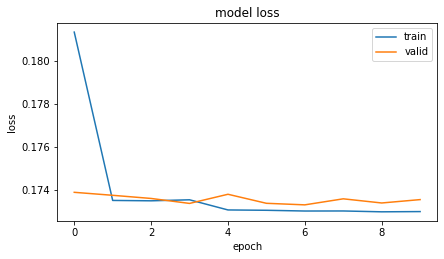

In [31]:
import matplotlib.pyplot as plt  

plt.figure(1, figsize = (15,8))  
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [32]:
fit_history.history.keys()

dict_keys(['loss', 'val_loss'])

In [33]:
model.load_weights('model-w.h5')

In [34]:
pred_y = model.predict_generator(test_gen, steps=test_gen.n/test_gen.batch_size, verbose = True)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1034/1034 [==============================] - 1025s 990ms/step


In [35]:
test_gen.reset()
test_x, test_y = next(test_gen)  
print(f"Diseases vector: {test_y[1]}")
print(f"Prediction product vector: {pred_y[2]}")

Diseases vector: [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Prediction product vector: [0.10150835 0.02827352 0.03967114 0.01696158 0.12652874 0.01799958
 0.0128028  0.00153397 0.18429022 0.0394049  0.05464168 0.03307269
 0.00896607 0.0478304 ]


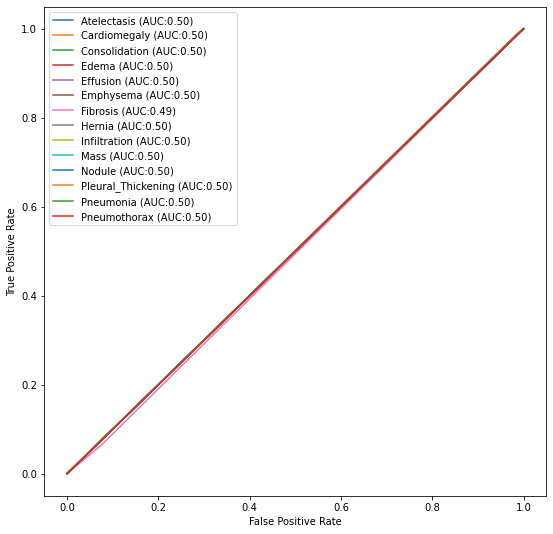

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
test_gen.reset()
test_x, test_y = next(test_gen)
# Space
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    #Points to graph
    fpr, tpr, thresholds = roc_curve(test_gen.labels[:,idx].astype(int), pred_y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    
#convention
c_ax.legend()

#Labels
c_ax.set_xlabel('False Positive Rate') 
c_ax.set_ylabel('True Positive Rate')

# Save as a png
fig.savefig('VGG16-Vital.png')

In [37]:
from sklearn.metrics import roc_auc_score
# ROC AUC
auc = roc_auc_score(test_gen.labels, pred_y)
print('ROC AUC: %f' % auc)

ROC AUC: 0.499782


In [ ]:
sickest_idx = np.argsort(np.sum(test_y, 1)<1)

#Space of images
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))

# Padding
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
counter = 0

for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    
    # Image show
    c_ax.imshow(test_x[idx, :,:,0], cmap = 'bone')
    
    stat_str = [n_class[:4] for n_class, n_score in zip(all_labels, test_y[idx]) if n_score>0.5]
    # Building the labels
    pred_str = [f'{n_class[:4]}:{p_score*100:.2f}%'
                for n_class, n_score, p_score 
                in zip(all_labels,test_y[idx],pred_y[idx]) 
                if (n_score>0.5) or (p_score>0.5)]
    
    c_ax.set_title(f'Index {idx}, Labels: '+', '.join(stat_str)+'\n Pred: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')